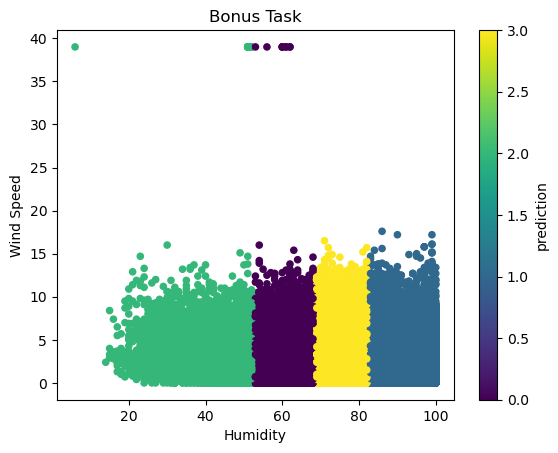

In [35]:
import pyspark.sql.functions as sparkFun
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

import pandas
import matplotlib.pyplot as plt
import sys

#Set a name for the application
appName = "DataFrame Example"

#Set the input folder location
input_folder = "in" 

#Set the input folder location
output_folder = "out" 

#create a new Spark application and get the Spark session object
spark = SparkSession.builder.appName(appName).getOrCreate()

#read in the CSV dataset as a DataFrame
#inferSchema option forces Spark to automatically specify data column types
#header option forces Spark to automatically fetch column names from the first line in the dataset files
weather_df = spark.read \
              .option("inferSchema", True) \
              .option("header", True) \
              .csv(input_folder)

#replacing null with 0
weather_df.na.fill(0)

#after checking Humidity with : weather_df.select("Humidity").orderBy("Humidity", ascending=True(and False) ).show(10, False)
#after checking Wind Speed with : weather_df.select("Wind Speed").orderBy("Wind Speed", ascending=True(and False) ).show(10, False)
#Humidity should be in [0,100] because %
#Wind Speed should be in [0,300] lets say becuase km/h
features_df = weather_df.select("Humidity", "Wind Speed") \
                        .filter((weather_df["Humidity"] >= 0) & (weather_df["Humidity"] <= 100) & \
                                (weather_df["Wind Speed"] >= 0) & (weather_df["Wind Speed"] <= 300))

#features_df.show(10, False) 

#assemble features into a vector column, transform the DataFrame to include the features as a dense vector
#This is ChatGPT ....
feature_vector_df = VectorAssembler(inputCols=["Humidity", "Wind Speed"], outputCol="features").transform(features_df)

#setting k to 4
kmeans = KMeans().setK(4)

#train/fit it to the dataset
model = kmeans.fit(feature_vector_df)

# Apply the KMeans model to the feature vector DataFrame to predict the clusters
prediction_df = model.transform(feature_vector_df)

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = prediction_df.toPandas()

#scatterplot graph
pandas_df.plot.scatter(x="Humidity", y="Wind Speed", c="prediction", colormap="viridis", title="Bonus Task")

plt.show()

#Stop Spark session
spark.stop()